# CMA/ES PER SUBJECT
## Sigma Base, 1st try: new cov, lapse + sigma_base, sum LL


Similar to [notebook_fitexperimentallt_sigmabase_cmaes_3try_090816.ipynb](../fitexperiment_sigmabaseline_cmaes_08_2016/notebook_fitexperimentallt_sigmabase_cmaes_3try_090816.ipynb)

But now with independent CMA/ES fits per subject, uses a subset of the data.

Should then reload all of them together and check if the mean of the parameter corresponds to the other CMA/ES fits we did.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [18]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import glob
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

## Reload data

In [19]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/

metric = 'dist_nll'
folder_pattern = "cmaes_subjects_bays09_ll_1try_Mratiosigmaxsigmabaselinelapserate_subject*rep5_160816"
re_subject = re.compile(".*subject([0-9]*)rep")

df_all_fits = None

for filename in glob.glob("./%s/outputs/cmaes_alliter_tracking*.npy" % folder_pattern):
    found = re_subject.match(filename)
    subject = int(found.group(1))
    print "Reloading data of Subject %d" % subject
    
    curr_cmaes_trace = np.load(filename).item()

    candidates_parameters = np.array(curr_cmaes_trace['candidates'])
    fitness = np.array(curr_cmaes_trace['fitness'])
    parameter_names_sorted = curr_cmaes_trace['parameter_names_sorted']
    
    df_fits_subject = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                               ('subject', subject),
                                               (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                               [(param, candidates_parameters[:, param_i]) 
                                                    for param_i, param in enumerate(parameter_names_sorted)])
    
    if df_all_fits is None:
        df_all_fits = df_fits_subject
    else:
        df_all_fits = df_all_fits.append(df_fits_subject, ignore_index=True)

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016
Reloading data of Subject 1
Reloading data of Subject 8
Reloading data of Subject 4
Reloading data of Subject 3
Reloading data of Subject 7
Reloading data of Subject 11
Reloading data of Subject 2
Reloading data of Subject 10
Reloading data of Subject 5
Reloading data of Subject 12
Reloading data of Subject 6
Reloading data of Subject 9


In [20]:
# Fix M and ratio_conj
M_corrected, ratio_corrected = utils.fix_M_ratioconj(df_all_fits['M'], df_all_fits['ratio_conj'])
df_all_fits.loc[:, 'M'] = M_corrected
df_all_fits.loc[:, 'ratio_conj'] = ratio_corrected

In [21]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000
df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

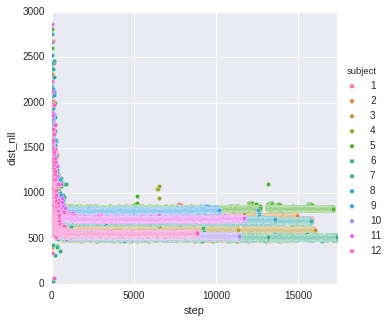

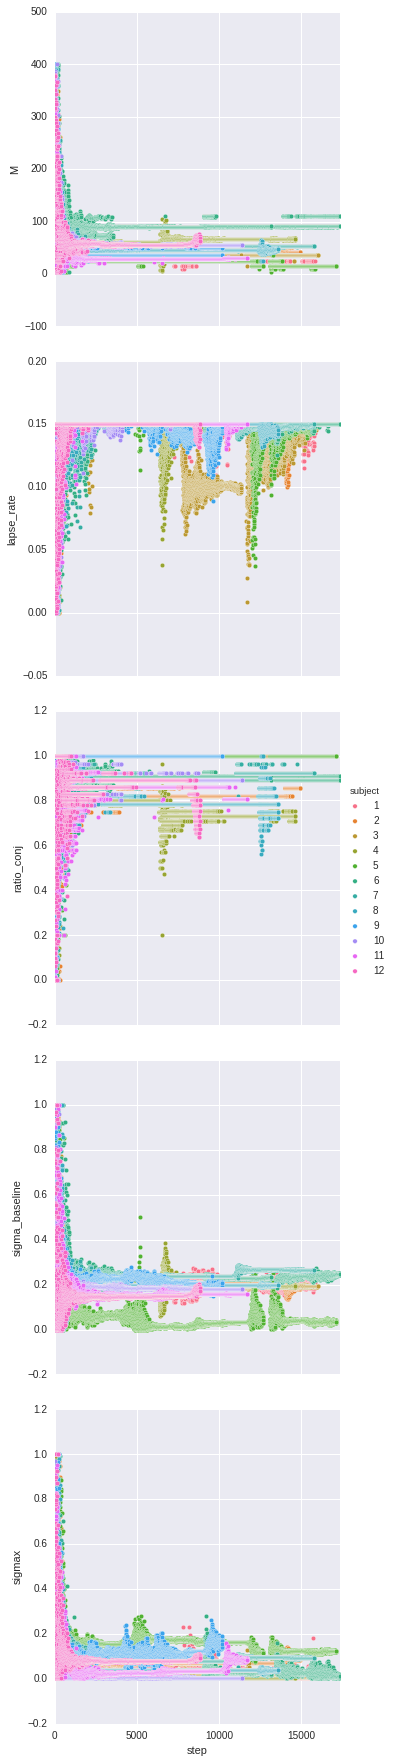

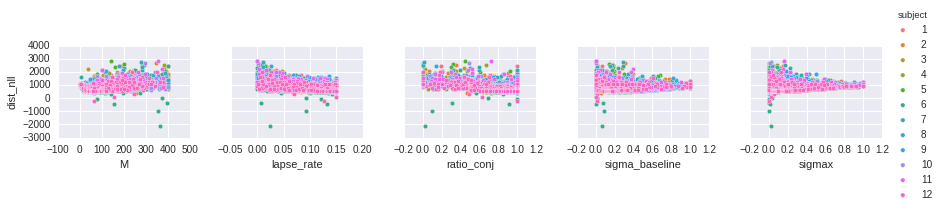

In [22]:
# Learning curve
g = sns.pairplot(df_best_fits,
                 y_vars=[metric],
                 x_vars=['step'],
                 hue='subject',
                 size=5,
                )

g.set(ylim=(-1, 3000),
      xlim=(-1, df_best_fits['step'].max())
     )

# Check training of parameters
g = sns.pairplot(df_best_fits,
                 y_vars=parameter_names_sorted,
                 x_vars=['step'],
                 hue='subject',
                 size=5
                )
g.set(xlim=(-1, df_best_fits['step'].max()))

# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=parameter_names_sorted,
             y_vars=[metric],
             hue='subject',
            )


## Check parameters values obtained

In [23]:
df_bestparams_subjects = df_best_fits.groupby('subject').apply(
    lambda subDf: subDf.sort_values('step', ascending=False).head(120).median()
)
df_bestparams_subjects

,step,subject,dist_nll,M,lapse_rate,ratio_conj,sigma_baseline,sigmax
subject,,,,,,,,
1,15778.5,1.0,701.304447,36.0,0.150000,1.000000,0.201067,0.005000
2,14879.5,2.0,738.277167,42.0,0.148007,0.857143,0.187498,0.090667
3,15929.5,3.0,593.524478,36.0,0.150000,1.000000,0.192290,0.010465
4,14549.5,4.0,503.068476,67.0,0.150000,0.731343,0.194534,0.005521
5,17069.5,5.0,830.582803,16.0,0.150000,1.000000,0.036228,0.124358
6,17279.5,6.0,511.066797,91.0,0.150000,0.890110,0.246068,0.012825
7,15689.5,7.0,693.717214,53.0,0.149870,0.924528,0.264210,0.093960
8,13529.5,8.0,703.482955,48.0,0.144244,0.750000,0.198810,0.039583
9,10138.5,9.0,809.722623,36.0,0.150000,1.000000,0.198341,0.162960


In [31]:
subject = 10

df_bestparams = df_bestparams_subjects.loc[subject]
df_bestparams

step              11308.500000
subject              10.000000
dist_nll            529.377001
M                    55.000000
lapse_rate            0.150000
ratio_conj            0.890909
sigma_baseline        0.181512
sigmax                0.005000
Name: 10, dtype: float64

In [32]:
import fitexperiment_allt
import fitexperiment_allt_subjects

%run /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/experimentlauncher.py \
--action_to_do launcher_do_fitexperiment_subject_allmetrics --inference_method none  --num_samples 200  --renormalize_sigma \
--autoset_parameters --code_type mixed  --sigmay 0.00001  --experiment_id bays09 \
--lapse_rate {df_bestparams['lapse_rate']} --M {int(np.round(df_bestparams['M']))} --sigmax {df_bestparams['sigmax']} \
--ratio_conj {df_bestparams['ratio_conj']} --sigma_baseline {df_bestparams['sigma_baseline']} \
--filter_datapoints_size 1500 --filter_datapoints_selection 'random' \
--experiment_subject {int(df_bestparams['subject'])}

Arguments: ['--action_to_do', 'launcher_do_fitexperiment_subject_allmetrics', '--inference_method', 'none', '--num_samples', '200', '--renormalize_sigma', '--autoset_parameters', '--code_type', 'mixed', '--sigmay', '0.00001', '--experiment_id', 'bays09', '--lapse_rate', '0.15', '--M', '55', '--sigmax', '0.005', '--ratio_conj', '0.890909090909', '--sigma_baseline', '0.181511782727', '--filter_datapoints_size', '1500', '--filter_datapoints_selection', 'random', '--experiment_subject', '10']

        Given a single experiment_id and a experiment_subject, will run the model on all T in the experimental data, for a particular subset of the data corresponding to that subject.

        Computes several metrics (LL, BIC) and can additionally sample from the model and check the Mixture model
        summary statistics fits.

        If inference_method is not none, also fits a EM mixture model, get the precision and the fisher information
    
Doing a piece of work for launcher_do_fitexperiment

In [33]:
plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)

Doing Paper plots for bays09. 
Fig5 1, Fig6 1, Fig13 1


DATA T 1
DATA T 2
mu: 0.374, kappa: 0.000
{'R': 12.579564784934478, 'u': -0.83873705427826162, 'pvalue': 0.79919155994472701, 'V': -7.2636759610030213}
DATA T 4
mu: -0.656, kappa: 0.045
{'R': 10.166822603034015, 'u': 0.53699109347876606, 'pvalue': 0.2956368831284738, 'V': 8.0548664021814904}
DATA T 6
mu: -0.248, kappa: 0.093
{'R': 34.956792651527579, 'u': 1.7498337996804003, 'pvalue': 0.040073498267215735, 'V': 33.88538582396518}


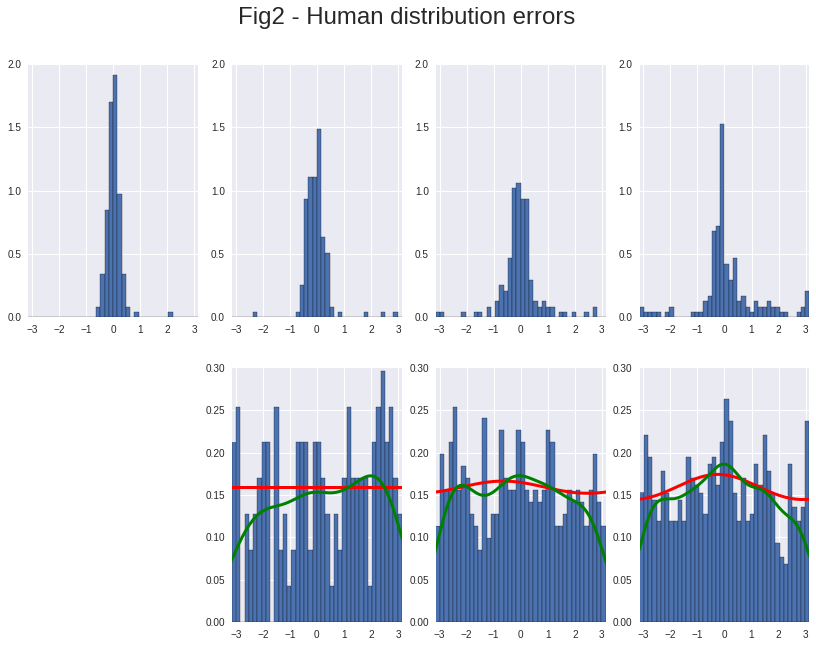

In [34]:
axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()

MODEL T 1
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -77.37
Loglikelihood: -41.62
top 90% loglike: 14.40
MODEL T 2
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -99.59
Loglikelihood: -121.11
top 90% loglike: -65.12
mu: 0.501, kappa: 0.000
{'R': 15.768673039578371, 'u': -1.055183772089509, 'pvalue': 0.85432935773957319, 'V': -9.1381595229060402}
MODEL T 4
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -161.16
Loglikelihood: -161.58
top 90% loglike: -106.23
mu: -0.158, kappa: 0.121
{'R': 27.267833428649645, 'u': 1.7952540090552196, 'pvalue': 0.036306619477478597, 'V': 26.928810135828293}
MODEL T 6
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -190.68
Loglikelihood: -191.63
top 90% loglike: -138.55
mu: 0.204, kappa: 0.138
{'R': 51.457891669734451, 'u': 2.6023700351517558, 'pvalue': 0.004629094921127952, 'V': 50.394679034059799}


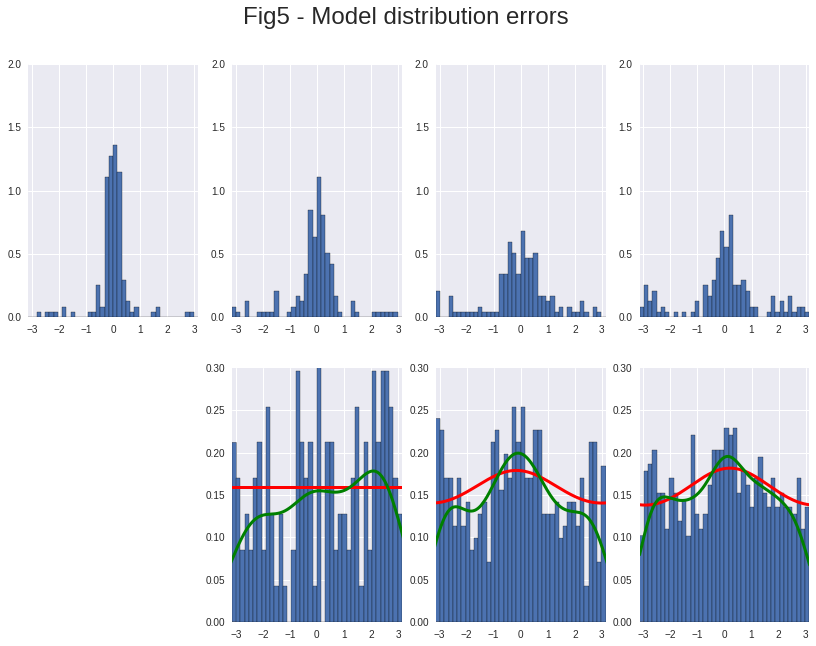

In [35]:
axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()

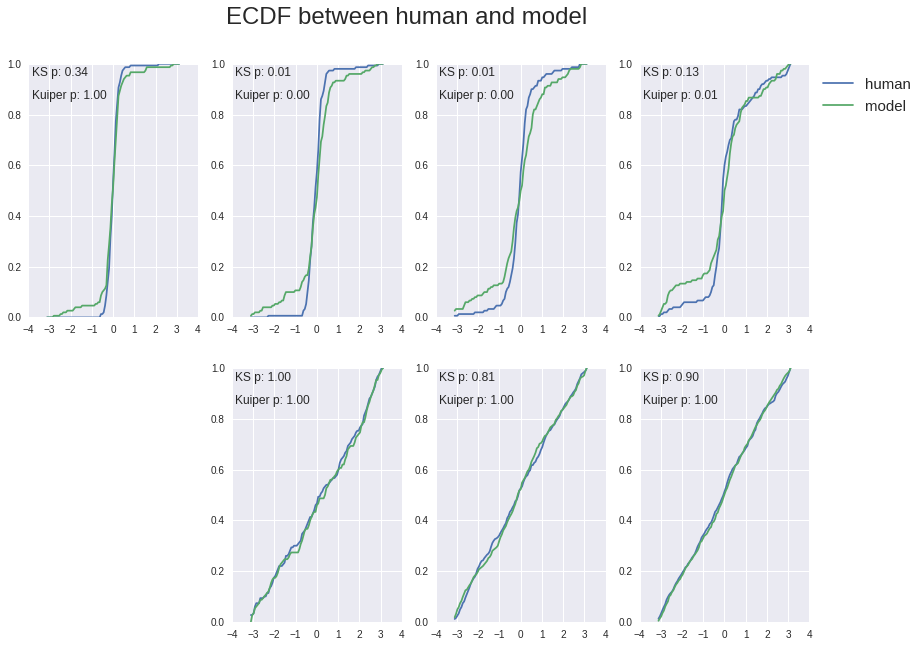

In [36]:
_ = plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)

0.00%, -- left - 18.08 21:10
Fit for T=1, 1/5
5.00%, 2s left - 18.08 21:10
Fit for T=1, 2/5
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -41.62
Loglikelihood: -23.77
top 90% loglike: 32.25
10.00%, 10s left - 18.08 21:10
Fit for T=1, 3/5
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -23.77
Loglikelihood: -31.26
top 90% loglike: 24.77
15.00%, 9s left - 18.08 21:10
Fit for T=1, 4/5
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -31.26
Loglikelihood: -18.33
top 90% loglike: 37.41
20.00%, 8s left - 18.08 21:10
Fit for T=1, 5/5
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -18.33
Loglikelihood: -25.03
top 90% loglike: 30.99
25.00%, 6s left - 18.08 21:10
Fit for T=2, 1/5
30.00%, 6s left - 18.08 21:10
Fit for T=2, 2/5
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -121.11
Loglikelihood: -126.65
top 90% loglike: -70.66
35.00%, 7s left - 18.08 21:10
Fit for T=2, 3/5
Ru

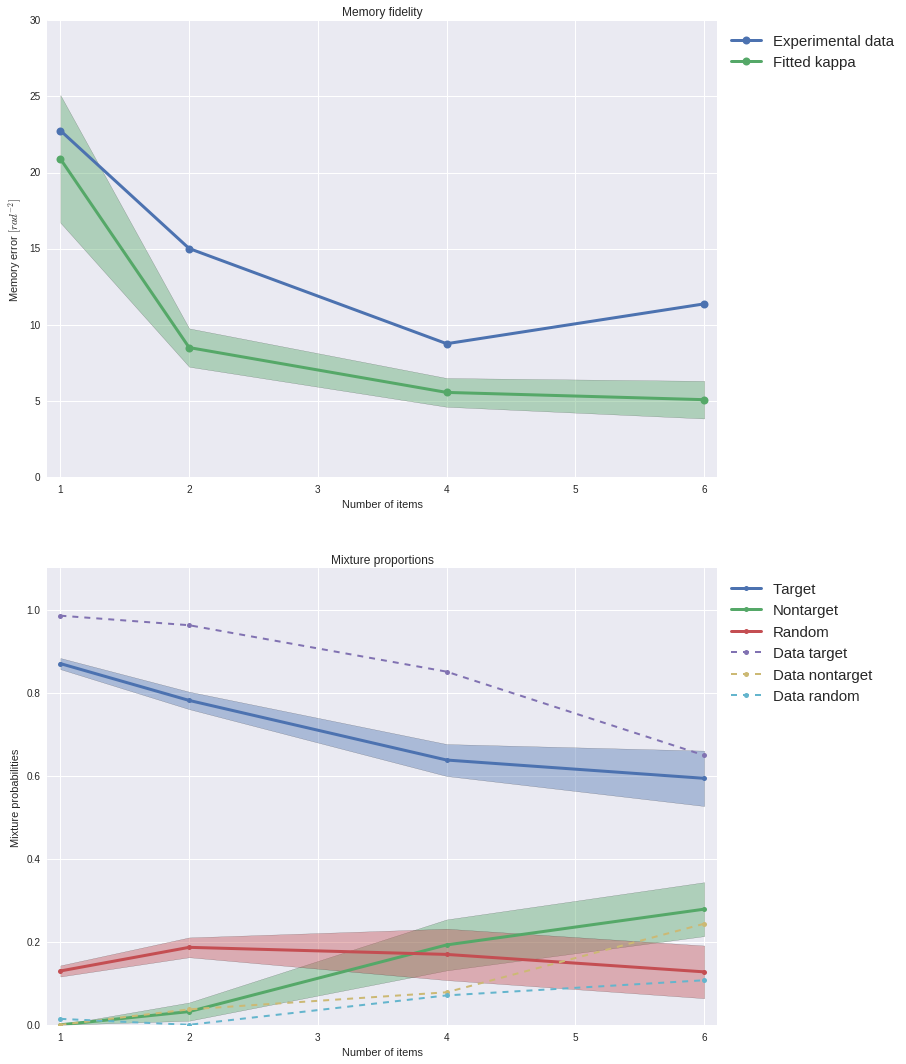

In [37]:
axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)

# Analyse me for all subjects